In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0     07f6e7e4-612b-43a0-a76a-3e4dd00e04b6
1     0c686a0f-b679-4ae6-925e-2e56eff72b09
2     48a2d93d-af2c-4d65-8f29-4728cf52d247
3     c4e6de39-8b5e-48d7-bf3e-61158bd5df2f
4     07770bb1-08c6-42ca-858e-d94f0579a379
                      ...                 
93    cd119ec0-fe63-4717-9a1e-e34d18f63007
94    7dd33ec6-4a78-4107-9c36-275ea246a79a
95    79abcb3e-abab-4b69-bf60-809caa32d135
96    5a57cccf-0496-4b9d-83c7-cc56dec24f08
97    a572cdd8-81de-4e04-a94e-e6becb591d6a
Length: 98, dtype: object

In [4]:
targets = eids[pd.Series(df_base["eid"].unique()).str.startswith("dcf0")]
targets

72    dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0
dtype: object

In [5]:
target_index = targets.index[0]

In [6]:
target_eid = df_base["eid"].unique()[target_index]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0'], dtype=object)

In [7]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)

In [8]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [9]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [10]:
df

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
0,4570,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,0.100000,"[50266.19440239298, -80827.62346610069]",30,-1.015427,"[25.154641139853258, -41.23563973805042]",3.084261e-01,"[14372.035065649125, 4294.718625445899]",...,-76480.416763,798.246191,189.783187,52.725694,-84.970590,NaN,18781.552040,48.302525,820.496581,15000.0
1,4571,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,0.266667,"[50270.47666780211, -80834.4692307323]",30,-0.926523,"[26.35231072865734, -40.877746519263255]",8.084261e-01,"[14372.035065649126, 4294.718625445899]",...,-76480.416763,798.246191,189.783187,60.061767,-79.953637,NaN,18778.972153,48.635732,820.496581,15000.0
2,4572,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,0.433333,"[50274.958544809386, -80841.2553464941]",30,-0.754285,"[27.549980317461422, -40.519853300476086]",1.308426e+00,"[14372.035065649125, 4294.718625445898]",...,-76480.416763,798.246191,189.783187,72.876118,-68.476795,NaN,18776.187378,48.998571,820.496581,15000.0
3,4573,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,0.600000,"[50279.64003341479, -80847.9818133861]",30,-0.498714,"[28.747649906265504, -40.16196008168892]",1.808426e+00,"[14372.035065649126, 4294.718625445898]",...,-76480.416763,798.246191,189.783187,87.819827,-47.829676,NaN,18773.197700,49.390388,820.496581,15000.0
4,4574,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,0.766667,"[50284.52113361832, -80854.6486314083]",30,-0.200990,"[29.945319495069587, -39.80406686290175]",1.587464e+00,"[14372.035065649126, 4294.718625445898]",...,-76480.416763,798.246191,189.783187,97.986947,-19.963925,NaN,18770.003108,49.810500,820.496581,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,5316,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,124.569308,"[49075.910161304586, -51429.34490094679]",30,5.615355,"[-1084.020149816393, 821.037706647211]",0.000000e+00,"[157136.24625936506, -123726.3113145954]",...,86659.392515,-99.045048,183.396763,78.516724,-61.928379,4414.513848,156939.753539,1359.853890,208.432949,200000.0
747,5317,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,124.735975,"[48896.222851038874, -51293.27779279403]",30,5.618688,"[-1070.911503695096, 810.7449441747459]",0.000000e+00,"[157517.34448978744, -123240.76510994899]",...,86659.392515,-77.555845,143.811282,78.722715,-61.666313,4191.183722,156734.672723,1343.189790,163.390924,200000.0
748,5318,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,124.902642,"[48718.72278073371, -51158.9229980565]",30,5.623777,"[-1057.769185425539, 800.4952140746534]",2.651993e-03,"[157951.08871372635, -122684.3656467626]",...,86659.392515,-56.409353,104.747526,79.035477,-61.264944,3970.840907,156532.192432,1326.524873,118.970834,200000.0
749,5319,SHP,dcf07fc2-5a4e-4acc-8674-2f4d871bdaf0,125.069308,"[48543.41590626341, -51026.27288032644]",30,5.624654,"[-1044.5884740914933, 790.2949073955018]",1.000000e-01,"[158446.32340605656, -122044.10104180919]",...,86659.392515,-35.658228,66.307283,79.089209,-61.195564,3753.515962,156332.306999,1309.859199,75.287217,200000.0


In [11]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'ct': '5abff6a4-c7cc-4bc6-945c-a699f7c6545a',
 'ct_loc': [48228.95341428717, -50861.83738262275],
 'ct_v': [0.0, 0.0],
 'ct_ts': 114.68597499999477,
 'ct_dv': [2062.045592374309, -2178.983243388917],
 'ct_tc': 0.0,
 'ct_ct': 2,
 'ct_cloc': [45937.613801318636, -48324.66641956663],
 'ct_cradius': 3518.694738892886,
 'ct_cn': [[48228.95341428717, -50861.83738262275],
  [43646.2741883501, -45787.495456510514]],
 'cac': True,
 'cbdr': False,
 'cbdr_hist': [[-649.4209116901184, 417.9279944350419],
  [-631.5942640374924, 404.4326954717253],
  [-613.7894994688322, 390.954506025475],
  [-596.0066237333958, 377.4934187404506],
  [-578.2456426559147, 364.04942615902837],
  [-560.5065621378599, 350.6225207199968],
  [-542.7893881587152, 337.21269475669396],
  [-525.0941267772505, 323.81994049515924],
  [-507.4207841328025, 310.4442500522491],
  [-489.7693664465405, 297.08561543375254],
  [-472.1398800227835, 283.7440285325065],
  [-454.5323312502

# Basic Ship Vitals

## Position and Heading

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=125.23597499999417, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

In [13]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,751.000000,751.000000
mean,63887.836625,-74903.276304
std,5853.029351,6358.703858
min,48370.309022,-80890.595703
25%,60705.463733,-77225.060830
50%,67522.686696,-76587.848446
75%,68109.104373,-76587.848446
max,68109.104373,-50895.318660


Text(0.5, 1.0, 'position')

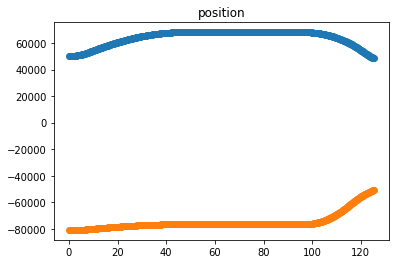

In [14]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

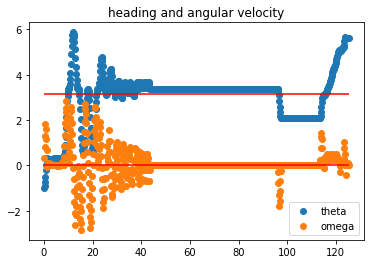

In [15]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

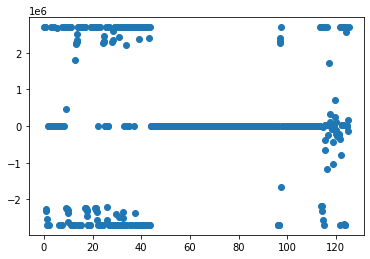

In [16]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

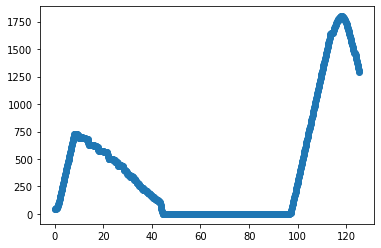

In [17]:
plt.scatter(df["ts"], df["speed"])

In [18]:
def plot_velocity(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["v.x"], label="x")
    plt.scatter(sample["ts"], sample["v.y"], label="y")
    plt.legend()
    plt.title("velocity")
    
ipywidgets.interact(plot_velocity, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_velocity(hist_length, max_time)>

In [19]:
def plot_acceleration(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (sample["v.x"].shift(1) - sample["v.x"]) / (sample["ts"].shift(1) - sample["ts"]), label="x")
    plt.scatter(sample["ts"], (sample["v.y"].shift(1) - sample["v.y"]) / (sample["ts"].shift(1) - sample["ts"]), label="y")
    plt.yscale("symlog")
    plt.legend()
    plt.title("acceleration")
    
ipywidgets.interact(plot_acceleration, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_acceleration(hist_length, max_time)>

In [20]:
def plot_force(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["f_mag"])
    plt.yscale("log")
    plt.title("force")

ipywidgets.interact(plot_force, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_force(hist_length, max_time)>

# Behavior Monitoring

In [21]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[113.56930833332817, None, 121.73597499999437, None]

In [22]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cbdr"]
    first_ts = [next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in flag_cols]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [23]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                             o.t_dist  \
                            count        min         max           min   
o.t_loc.x     o.t_loc.y                                                  
-25500.137199  86659.392515   175  96.235975  125.235975  156135.01014   
 68537.715710 -76480.416763   265   0.100000   44.235975     442.97283   

                                            
                                       max  
o.t_loc.x     o.t_loc.y                     
-25500.137199  86659.392515  188181.667618  
 68537.715710 -76480.416763   18781.552040

In [24]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o.t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o.t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_target_distance(hist_length, max_time)>

In [25]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

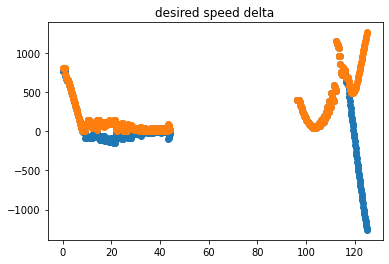

In [26]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

### Collision Threats

In [27]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.show_collision_threats(hist_length, max_time)>

In [28]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+500+500, color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+500, color="orange", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"], color="red", marker="_")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(sample["o.ct_dist"].min())

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_distance(hist_length, max_time)>

Text(0.5, 1.0, 'Collision Threat and Time Since Detection')

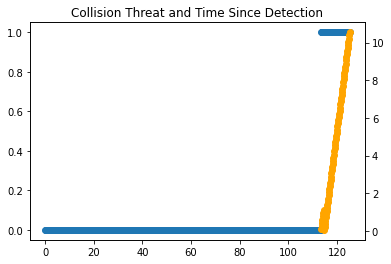

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")
plt.title("Collision Threat and Time Since Detection")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [30]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

In [31]:
def plot_collision_threat_loc(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_cloc.x"])
    ax2.scatter(sample["ts"], sample["o.ct_cloc.y"], color="orange")
    plt.title("collision threat coalesced location")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_loc,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_threat_loc(hist_length, max_time)>

In [32]:
def plot_collision_threat_radius(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_cradius"])
    plt.title("collision threat radius")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_radius,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_threat_radius(hist_length, max_time)>

## Nearest Neighbors

In [33]:
neighborhood_radius = 5e4
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nd"]*np.pi*neighborhood_radius**2)
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [34]:
def plot_nearest_neighbor(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nnd"])
    plt.title("nearest neighor dist")
    plt.show()

ipywidgets.interact(
    plot_nearest_neighbor,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_nearest_neighbor(hist_length, max_time)>

In [35]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_dv(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [36]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    if show_v:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"]+ctdv_df["v.x"], ctdv_df["o.ct_dv.y"]+ctdv_df["v.y"], label="ctdv", color="orange")
    if show_tv:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o.ct_v.x"], sample["o.ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample[~(sample["o.ct_cloc"].isna())]
    if len(cloc_df) > 0:
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+30+500*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(cradius)
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=2, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_chart(hist_length=125.23597499999417, max_time=125.23597499999417, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True)>

## Position and Heading

In [37]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    #plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    #plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=125.1359…

<function __main__.plot_collision_chart(hist_length=125.23597499999417, max_time=125.23597499999417)>

In [38]:
for s in df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc":"min", "o.ad":"min"}).values:
    print(f'{s}')

[list([-25500.137198976492, 86659.39251476736]) 500.0]
[list([68537.7157103536, -76480.41676322695]) 500.0]


# 